<a href="https://colab.research.google.com/github/bulinayas/Deep-deep-learning/blob/main/%5Bseminar%5Dmlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500,>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Многослойная сеть на PyTorch</b></h3>

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть (датасет - снова "Игрушка дьявола"):

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

Генерация и отрисовка датасета:

In [313]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

In [302]:
ind = np.arange(0, len(X))
np.random.shuffle(ind)
ind

array([219, 162,  18,  69,  27, 105, 118, 277, 122, 165, 246, 208,  62,
       155,  29,  88, 212, 195, 257, 259, 174, 149,  35, 288,  28, 178,
        70, 209,  98,  99, 249,  15, 251,  84, 116, 245,  31,  66,  86,
       283, 127, 296, 222,  43, 189,  97,  60,  72,   9, 181, 102, 187,
       172,  94,  78,  34,  40, 201, 159,  42,  65, 265, 216, 247, 193,
       269,  67, 210, 135, 161, 248, 284, 110, 138, 144,  46, 267, 112,
       202, 169, 106,  96, 164, 286, 114, 200, 280, 273, 232, 183, 237,
       197, 142, 276, 266, 107, 188, 141, 166,  50, 229, 194, 281,  49,
        44, 179,  37,  68, 129, 173, 133,  36, 156, 137,  39, 151, 250,
       254, 109, 290,  82, 132,  13, 117,  93,  10, 125,   5, 205, 134,
       167,  11, 297,  95,  17, 198, 180, 211, 121, 100, 139, 291, 287,
       203,  45, 119, 293, 185, 196, 298, 292, 140, 168, 186,  85, 115,
       234, 214,  89,   4, 279,  47, 160, 256, 120,  52,   0, 153,  77,
       260,   1, 170, 235,  12,  23, 177, 104, 255, 243, 182, 27

In [254]:
X = X[ind]
y = y[ind]

Не забываем оборачивать данные (без этого градиенты не посчитать):

In [255]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [221]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Сама ячейка с сеткой и обучением:

In [256]:
class MyModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super().__init__()
        self.lin1 = torch.nn.Linear(D_in, 100)
        self.lin2 = torch.nn.Linear(100, 150)
        self.lin3 = torch.nn.Linear(150, D_out)
    def forward(self, X):
        X = torch.nn.functional.relu(self.lin1(X))
        X = torch.nn.functional.relu(self.lin2(X))
        X = self.lin3(X)
        return X
        

In [268]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 3

model = MyModel(D_in, D_out)

# Use the nn package to define our model and loss function.
#two_layer_net = torch.nn.Sequential(
 #   torch.nn.Linear(D_in, H, bias=False),
  #  torch.nn.ReLU(),
   # torch.nn.Linear(H, D_out),
#)

two_layer_net = model

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 331.620849609375
1 330.7235412597656
2 329.8446960449219
3 328.9807434082031
4 328.13189697265625
5 327.2998962402344
6 326.4833984375
7 325.67877197265625
8 324.8831787109375
9 324.0947570800781
10 323.3132629394531
11 322.53802490234375
12 321.76849365234375
13 321.0056457519531
14 320.248779296875
15 319.4975280761719
16 318.7517395019531
17 318.0093994140625
18 317.2680969238281
19 316.52838134765625
20 315.79351806640625
21 315.061279296875
22 314.3326721191406
23 313.6103515625
24 312.893310546875
25 312.18048095703125
26 311.470703125
27 310.7646789550781
28 310.0602722167969
29 309.35736083984375
30 308.65692138671875
31 307.9590148925781
32 307.26373291015625
33 306.5701904296875
34 305.8785095214844
35 305.1893310546875
36 304.50128173828125
37 303.8147888183594
38 303.12939453125
39 302.4465637207031
40 301.7668762207031
41 301.0902404785156
42 300.4150390625
43 299.7401428222656
44 299.067138671875
45 298.39727783203125
46 297.7305908203125
47 297.0661926269531
48 296.403

**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

In [224]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

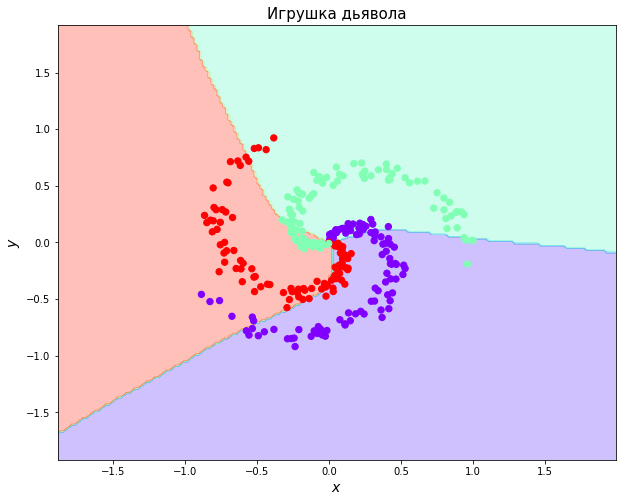

In [226]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

### Задача 2

Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

*Другие функции активации, больше иттераций*

In [391]:
from torch.nn import Linear,ReLU,CrossEntropyLoss
from torch.optim import SGD
from torch.nn.functional import relu,softmax,sigmoid,leaky_relu,elu

In [370]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

In [371]:
X = X[ind]
y = y[ind]

In [372]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [392]:
class MyModel(torch.nn.Module):
  def __init__(self,D_in,D_out):
    super().__init__()
    self.lin1=Linear(D_in,100)
    self.lin2=Linear(100,150)
    self.lin3=Linear(150,D_out)

  def forward(self,X):
    X=elu(self.lin1(X))
    X=leaky_relu(self.lin2(X))
    X=sigmoid(self.lin3(X))
    return X

In [393]:
# N - batch_size
# D_in - вход;
# H - размерность скрытых слоёв; 
# D_out - выход.
N, D_in, H, D_out = 64, 2, 100, 3

model=MyModel(D_in,D_out)
num_epochs=5000
learning_rate=1e-3

loss_fn=CrossEntropyLoss(size_average=False)
optimizer=SGD(model.parameters(),lr=learning_rate)

for i in range(num_epochs):

  y_pred=model(X)
  loss=loss_fn(y_pred,y)
  print('{} {}'.format(i,loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Выходные данные были обрезаны до нескольких последних строк (5000).
0 330.3658752441406
1 329.5225524902344
2 328.6997985839844
3 327.8922119140625
4 327.09088134765625
5 326.2943420410156
6 325.50537109375
7 324.7150573730469
8 323.9193420410156
9 323.1144714355469
10 322.30059814453125
11 321.4769287109375
12 320.6361389160156
13 319.7778625488281
14 318.9041442871094
15 318.0111999511719
16 317.1025390625
17 316.17950439453125
18 315.2459716796875
19 314.2947692871094
20 313.3235168457031
21 312.3325500488281
22 311.33197021484375
23 310.321044921875
24 309.3063659667969
25 308.2898864746094
26 307.2690734863281
27 306.246337890625
28 305.22369384765625
29 304.201416015625
30 303.1813659667969
31 302.165283203125
32 301.1537780761719
33 300.1510314941406
34 299.1601867675781
35 298.184814453125
36 297.22418212890625
37 296.2828369140625
38 295.36029052734375
39 294.45751953125
40 293.5759582519531
41 292.7169494628906
42 291.8799743652344
43 291.0649108886719
44 290.2715148925781
45

In [394]:
XX = X.data.numpy()
Yy = y.data.numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


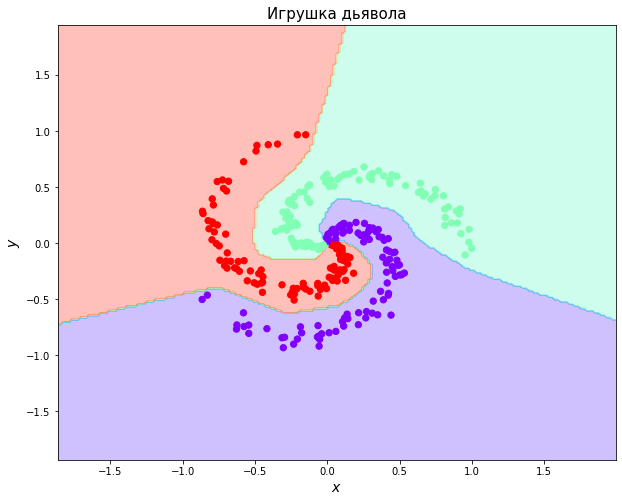

In [395]:
h = 0.02
x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = model(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(XX[:, 0], XX[:, 1], c=Yy, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

*Больше "помощников". И чуть больше иттераций*

In [428]:
class MyModel(torch.nn.Module):
  def __init__(self,D_in,D_out):
    super().__init__()
    self.lin1=Linear(D_in,200)
    self.lin2=Linear(200,200)
    self.lin3=Linear(200,150)
    self.lin4=Linear(150,D_out)

  def forward(self,X):
    X=elu(self.lin1(X))
    X=leaky_relu(self.lin2(X))
    X=leaky_relu(self.lin3(X))
    X=sigmoid(self.lin4(X))
    return X

In [425]:
D_in,D_out=2,3

num_epochs=1000
learning_rate=1e-3

model=MyModel(D_in,D_out)

loss_fn=CrossEntropyLoss(size_average=False)
optimizer=SGD(model.parameters(),lr=learning_rate)

for i in range(num_epochs):
  y_pred=model(X)
  loss=loss_fn(y_pred,y)

  print('{} {}'.format(i,loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 329.20684814453125
1 328.880859375
2 328.554443359375
3 328.2249755859375
4 327.8942565917969
5 327.56329345703125
6 327.2313232421875
7 326.89813232421875
8 326.5573425292969
9 326.20904541015625
10 325.8537902832031
11 325.4904479980469
12 325.11907958984375
13 324.73828125
14 324.3419189453125
15 323.92730712890625
16 323.4923400878906
17 323.0362854003906
18 322.5560302734375
19 322.0476989746094
20 321.5086364746094
21 320.9393005371094
22 320.3417053222656
23 319.7093505859375
24 319.0435485839844
25 318.3465576171875
26 317.614013671875
27 316.8480529785156
28 316.0430603027344
29 315.1974792480469
30 314.30718994140625
31 313.3705139160156
32 312.3873596191406
33 311.358154296875
34 310.28192138671875
35 309.16094970703125
36 308.0005187988281
37 306.80926513671875
38 305.5859069824219
39 304.33502197265625
40 303.0606689453125
41 301.768798828125
42 300.4654846191406
43 299.1578063964844
44 297.8519592285156
45 296.5561218261719
46 295.2728271484375
47 294.006591796875
48 29

In [426]:
XX=X.data.numpy()
Yy=y.data.numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


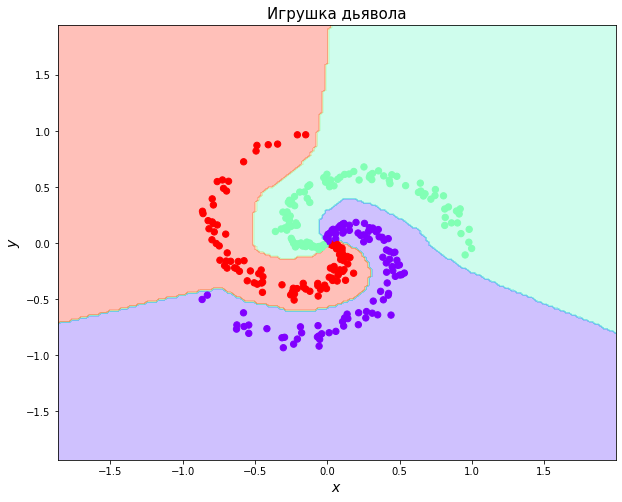

In [427]:
h = 0.02
x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = model(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(XX[:, 0], XX[:, 1], c=Yy, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

*Т.е. результат почти тот же(визуально), а иттераций в 5 раз меньше за счет увеличения кол-ва слоев и нейронов.*

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*